In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
yelp_train = pd.read_csv('yelp242_train.csv')
yelp_test = pd.read_csv('yelp242_test.csv')
yelp_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6272 entries, 0 to 6271
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stars                       6272 non-null   float64
 1   review_count                6272 non-null   int64  
 2   GoodForKids                 6272 non-null   object 
 3   Alcohol                     6272 non-null   object 
 4   BusinessAcceptsCreditCards  6272 non-null   object 
 5   WiFi                        6272 non-null   object 
 6   BikeParking                 6272 non-null   object 
 7   ByAppointmentOnly           6272 non-null   object 
 8   WheelechairAccessible       6272 non-null   object 
 9   OutdoorSeating              6272 non-null   object 
 10  RestaurantsReservations     6272 non-null   object 
 11  DogsAllowed                 6272 non-null   object 
 12  Caters                      6272 non-null   object 
dtypes: float64(1), int64(1), object(1

## New Variable - fourOrAbove

Equal to 1 if stars is greater than or equal to 4 and equal to 0
otherwise.

In [3]:
yelp_train['fourOrAbove'] = np.where(yelp_train['stars'] >= 4.0 , 1, 0)
yelp_test['fourOrAbove'] = np.where(yelp_test['stars'] >= 4.0 , 1, 0)

In [4]:
#print(yelp_train['stars'][1])

In [5]:
#for i in range(len(yelp_train['stars'])):
#   if yelp_train['stars'][i] >= 4:
#      yelp_train['fourOrAbove'][i] = 1
#   else:
#      yelp_train['fourOrAbove'][i] = 0 

In [6]:
#yelp_train.head(10)

In [7]:
yelp_train = yelp_train.drop(['stars'], axis=1)
yelp_test = yelp_test.drop(['stars'], axis=1)
#yelp_train.info()

In [8]:
y_train = yelp_train['fourOrAbove']
y_test = yelp_test['fourOrAbove']
X_train = yelp_train.drop(['fourOrAbove'], axis=1)
X_test = yelp_test.drop(['fourOrAbove'], axis=1)

In [12]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()

X_train_enc = X_train.select_dtypes(include='object').apply(labelencoder.fit_transform)
X_test_enc = X_test.select_dtypes(include='object').apply(labelencoder.fit_transform)

X_train_new = pd.concat([X_train.drop(X_train_enc.columns, axis=1), X_train_enc], axis=1)
X_test_new = pd.concat([X_test.drop(X_test_enc.columns, axis=1), X_test_enc], axis=1)

## Decision Tree Classifier

In [9]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score 

In [11]:
dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.001,
                              class_weight = 'balanced',
                              random_state = 88)

dtc = dtc.fit(X_train_new, y_train)

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(dtc, 
          feature_names=X_train_new.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth=3) 
plt.show()

y_pred = dtc.predict(X_test_new)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

NameError: name 'X_train_new' is not defined

## Logistic Regression Model

In [13]:
import os
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf

logreg = smf.logit(formula = "fourOrAbove ~ review_count +  C(GoodForKids, Treatment(reference='(Missing)')) + C(Alcohol, Treatment(reference='(Missing)')) + C(BusinessAcceptsCreditCards, Treatment(reference='(Missing)')) + C(WiFi, Treatment(reference='(Missing)')) + C(BikeParking, Treatment(reference='(Missing)')) + C(ByAppointmentOnly, Treatment(reference='(Missing)')) + C(WheelechairAccessible, Treatment(reference='(Missing)')) + C(OutdoorSeating, Treatment(reference='(Missing)')) + C(RestaurantsReservations, Treatment(reference='(Missing)')) + C(DogsAllowed, Treatment(reference='(Missing)')) + C(Caters, Treatment(reference='(Missing)'))",
                       data = yelp_train).fit()
print(logreg.summary())

Optimization terminated successfully.
         Current function value: 0.604944
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            fourOrAbove   No. Observations:                 6272
Model:                          Logit   Df Residuals:                     6246
Method:                           MLE   Df Model:                           25
Date:                Thu, 02 Mar 2023   Pseudo R-squ.:                  0.1193
Time:                        19:48:47   Log-Likelihood:                -3794.2
converged:                       True   LL-Null:                       -4308.3
Covariance Type:            nonrobust   LLR p-value:                6.235e-201
                                                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------

In [14]:
def convert_to_binary(predictions):
    binary_predictions = np.zeros(predictions.shape)
    binary_predictions[predictions >= 0.5] = 1
    return binary_predictions.astype(int)

from sklearn.metrics import confusion_matrix

y_test2 = convert_to_binary(y_test)
y_pred = convert_to_binary(logreg.predict(X_test))
cm = confusion_matrix(y_test2, y_pred)

print ("Confusion Matrix : \n", cm) 

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[1241  279]
 [ 608  560]]
Accuracy is: 0.6700
TPR is: 0.4795
FPR is: 0.1836


## Complexity Parameter

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

grid_values = {'ccp_alpha': np.linspace(0, 0.10, 201),
               'min_samples_leaf':[5],
               'min_samples_split': [20],
               'max_depth':[30],
               'random_state':[88]}

dtc = DecisionTreeClassifier()
dtc_cv_acc = GridSearchCV(dtc, param_grid = grid_values, scoring='accuracy', cv=10, verbose=1)
dtc_cv_acc.fit(X_train_new, y_train)

Fitting 10 folds for each of 201 candidates, totalling 2010 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035,
       0.004 , 0.0045, 0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075,
       0.008 , 0.0085, 0.009 , 0.0095, 0.01  , 0.0105, 0.011 , 0.0115,
       0.012 , 0.0125, 0.013 , 0.0135, 0.014 , 0.0145, 0.015 , 0.0155,
       0.016 , 0.0165, 0.017 , 0.0175, 0.018 , 0.0185, 0.019 , 0.0195,
       0.02  , 0.02...
       0.08  , 0.0805, 0.081 , 0.0815, 0.082 , 0.0825, 0.083 , 0.0835,
       0.084 , 0.0845, 0.085 , 0.0855, 0.086 , 0.0865, 0.087 , 0.0875,
       0.088 , 0.0885, 0.089 , 0.0895, 0.09  , 0.0905, 0.091 , 0.0915,
       0.092 , 0.0925, 0.093 , 0.0935, 0.094 , 0.0945, 0.095 , 0.0955,
       0.096 , 0.0965, 0.097 , 0.0975, 0.098 , 0.0985, 0.099 , 0.0995,
       0.1   ]),
                         'max_depth': [30], 'min_samples_leaf': [5],
                         'min_samples_split': [20], 'random_state': [88]},
            

In [16]:
acc = dtc_cv_acc.cv_results_['mean_test_score'] 
ccp = dtc_cv_acc.cv_results_['param_ccp_alpha'].data

#pd.DataFrame({'ccp alpha' : ccp, 'Validation Accuracy' : acc}).head(20)

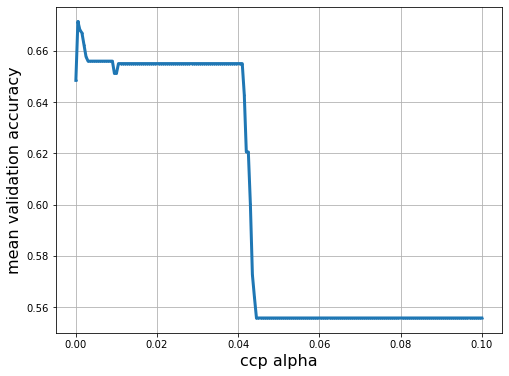

In [17]:
plt.figure(figsize=(8, 6))
plt.xlabel('ccp alpha', fontsize=16)
plt.ylabel('mean validation accuracy', fontsize=16)
plt.scatter(ccp, acc, s=2)
plt.plot(ccp, acc, linewidth=3)
plt.grid(True, which='both')
plt.show()

In [18]:
print('Grid best parameter ccp_alpha (max. Accuracy): ', dtc_cv_acc.best_params_['ccp_alpha'])
print('Grid best score (Accuracy): ', dtc_cv_acc.best_score_)

Grid best parameter ccp_alpha (max. Accuracy):  0.0005
Grid best score (Accuracy):  0.6713954834973943


Node count = 91


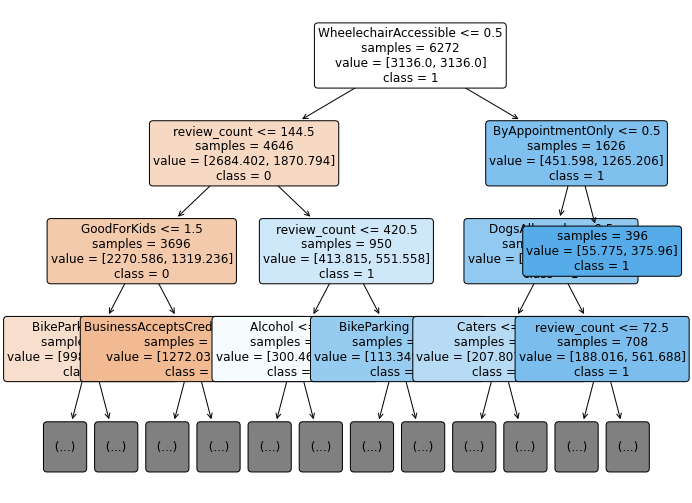

NameError: name 'df_test' is not defined

In [27]:
#build a classification tree model with the selected complexity parameter
dtc = DecisionTreeClassifier(min_samples_leaf=5, 
                              ccp_alpha=0.0005,
                              class_weight = 'balanced',
                              random_state = 88)

dtc = dtc.fit(X_train_new, y_train)

print('Node count =', dtc.tree_.node_count)
plt.figure(figsize=(11,9))
plot_tree(dtc, 
          feature_names=X_train_new.columns, 
          class_names=['0','1'], 
          filled=True,
          impurity=False,
          rounded=True,
          fontsize=12,
          max_depth=3) 
plt.show()

y_pred = dtc.predict(X_test_new)
cm = confusion_matrix(y_test, y_pred)

print ("Confusion Matrix : \n", cm) 
# print('Precision:',precision_score(y_test, y_pred))
# print('Recall:',recall_score(y_test, y_pred))

acc = (cm.ravel()[0]+cm.ravel()[3])/sum(cm.ravel())
TPR = cm.ravel()[3]/(cm.ravel()[3]+cm.ravel()[2])
FPR = cm.ravel()[1]/(cm.ravel()[1]+cm.ravel()[0])
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

## Baseline Model

In [20]:
print ("Confusion Matrix : \n [[1520  0]\n [ 1168  0]]") 
acc = (1520/2688)
TPR = (0/1168)
FPR = (0/1520)
print('Accuracy is: %.4f' %acc)
print('TPR is: %.4f' % TPR)
print('FPR is: %.4f' % FPR)

Confusion Matrix : 
 [[1520  0]
 [ 1168  0]]
Accuracy is: 0.5655
TPR is: 0.0000
FPR is: 0.0000
